# AUS2200 rainfall plot

In this notebook we will show you how to:

- Open data from the AUS2200 simulation post-processed output
- Extract the variable you need (rainfall in this case)
- Plot this data onto a map of Australia

#### Please note the 1hr and daily rainfall data listed here is wrong we are re-calculating it

### Load the libraries

In [1]:
#Data libraries:
import xarray as xr
import numpy as np

# Plotting libraries:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
# Let's load Dask to make Xarray more efficient
import dask.distributed as dsk

# Start client
clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42061,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:43923,Total threads: 1
Dashboard: /proxy/41437/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:40997,


- Dask speeds up analysis of the data, some of these files are quite big.
- You can find task on the toolbar on the left.
- Enter /proxy/8787/status (or whatever dashboard you are given) as the url.
- Using the 'Progress' window lets you see what tasks are happening when you run a command.

## Access data

We extracted some of the variables and save them in single field files. The files are in the folder:<br>
<br>/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/data<br>

The available surface variables are:<br>

- 10min:
    - accumulated large-scale rainfall: accum_ls_prcp_10min_YYYYMMDD.nc 1 file X day
    - accumulated large-scale snowfall: accum_ls_snow_10min_20220222_20220307.nc
<br><br>
- 1hr: {varname}_1hr_20220222_20220307.nc: 
    - accumulated large-scale rainfall: accum_ls_prcp
    - accumulated large-scale snowfall: accum_ls_snow
    - evaporation flux from open sea  : av_accum_evap_sea    
    - canopy water amount: canopy_wtr_cont    
    - dew point temperature: d2m                
    - specific humidity: hus                
    - latent heat flux: lat_hflx           
    - soil moisture content: mrso                          
    - surface altitude: orog              
    - air pressure at sea level: psl               
    - surface downwelling longwave flux: rlds               
    - surface net downward longwave_flux: rls                
    - toa outgoing longwave flux: rlut             
    - surface downwelling shortwave flux: rsds 
    - toa incoming shortwave flux: rsdt
    - toa outgoing shortwave flux: rsut
    - sensible heat flux: sens_hflx  
    - surface upward water flux: sfc_mois_flx
    - soil temperature: soil_temp
    - surface roughness length: sfc_rlen
    - air temperature mean: tas
    - air temperature maximum: tasmax
    - air temperature minimum: tasmin
    - eastward wind stress: uwnd_strs
    - visibility in air: visibility
    - northward wind stress: vwnd_strs
    - maximum wind gust: wndgust
    - x_wind: x_wind
    - y_wind: y_wind
    - atmosphere boundary layer thickness: zmla 
<br><br>    
- 6hr: {varname}_6hr_20220222_20220307.nc: 
    - accumulated large-scale rainfall: accum_ls_prcp
    - accumulated large-scale snowfall: accum_ls_snow
<br><br>
- day: <varname>_day_20220222_20220307.nc: 
    - accumulated large-scale rainfall: accum_ls_prcp
    - accumulated large-scale snowfall: accum_ls_snow

Let's open 1-hourly accumulated large-scale rainfall data into Xarray.

In [3]:
datadir = '/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/data'
fname = 'accum_ls_prcp_1hr_20220222_20220307.nc'

In [4]:
ds = xr.open_dataset(f'{datadir}/{fname}', chunks = {'time': '200mb'})
ds
# It's good to set chunk size when opening data so Xarray/Dask is more efficient.
# the setting above makes sure we are using chunksizes ~200MB of size which is optimal for dask.

# If you want to do timeseries type operations you might want to specify the chunks as:
# chunks = {'time':-1, 'latitude': '200MB}
# In this way all timesteps for a single cell grid will be in the same chunk

<xarray.Dataset>
Dimensions:        (time: 336, latitude: 2120, longitude: 2600)
Coordinates:
  * latitude       (latitude) float32 -48.79 -48.77 -48.75 ... -6.852 -6.832
  * longitude      (longitude) float32 107.5 107.5 107.6 ... 158.9 159.0 159.0
  * time           (time) datetime64[ns] 2022-02-22 ... 2022-03-07T23:00:00
Data variables:
    accum_ls_prcp  (time, latitude, longitude) float64 dask.array<chunksize=(4, 2120, 2600), meta=np.ndarray>
Attributes:
    history:  Fri Feb 10 11:32:54 2023: ncks --fix_rec_dmn time accum_ls_prcp...
    NCO:      netCDF Operators version 5.0.5 (Homepage = http://nco.sf.net, C...

In [ ]:
# To open the 10min data which is stored in several files use open_mfdataset() instead
# fname = 'accum_ls_prcp_10min_2022*.nc'
#ds = xr.open_mfdataset(f'{datadir}/{fname}', chunks = {'time': '200mb'}, parallel=True)

## Extract 

Now let's select `accum_ls_prcp`

In [7]:
pr_1hr = ds.accum_ls_prcp

Printing the pr_1hr variable shows us what is inside.

In [6]:
pr_1hr

<xarray.DataArray 'accum_ls_prcp' (time: 336, latitude: 2120, longitude: 2600)>
dask.array<open_dataset-3a5e65d1ea17393e4577fecb9bc21365accum_ls_prcp, shape=(336, 2120, 2600), dtype=float64, chunksize=(4, 2120, 2600), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -48.79 -48.77 -48.75 ... -6.871 -6.852 -6.832
  * longitude  (longitude) float32 107.5 107.5 107.6 107.6 ... 158.9 159.0 159.0
  * time       (time) datetime64[ns] 2022-02-22 ... 2022-03-07T23:00:00
Attributes:
    standard_name:  stratiform_rainfall_amount
    units:          kg m-2
    source:         Data from Met Office Unified Model
    um_version:     12.2
    STASH:          [  1   4 201]
    cell_methods:   time: mean (interval: 1 hour)

## Plot a timeseries

To select a timeseries at one specific point we can use sel().<br>
Let's check the rainfall in Brisbane (27.4705° S, 153.0260° E) during that period. We have to use `method=nearest` to get the nearest grid cell to the coordinates we passed.

In [8]:
brisbane = pr_1hr.sel(latitude=-27.4705, longitude=153.026, method='nearest')
print(brisbane.latitude.values, brisbane.longitude.values)

-27.463398 153.0204


Plotting a timeseries is straigthforward we can just call plot() on the array

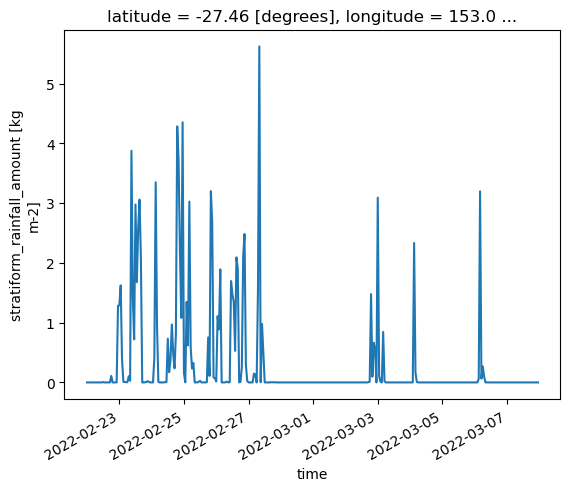

In [9]:
brisbane.plot()

## Plot a map

Let's access the daily accumulated rainfall and plot a map of the entire domain. This time we will add some plotting settings to have more control on the result.

In [18]:
fday = "accum_ls_prcp_day_mean_20220202_20220307.nc"
ds_day = xr.open_dataset(f'{datadir}/{fday}', chunks = {'time': '200mb'})
pr_day = ds_day.accum_ls_prcp

Now we can configure the plot

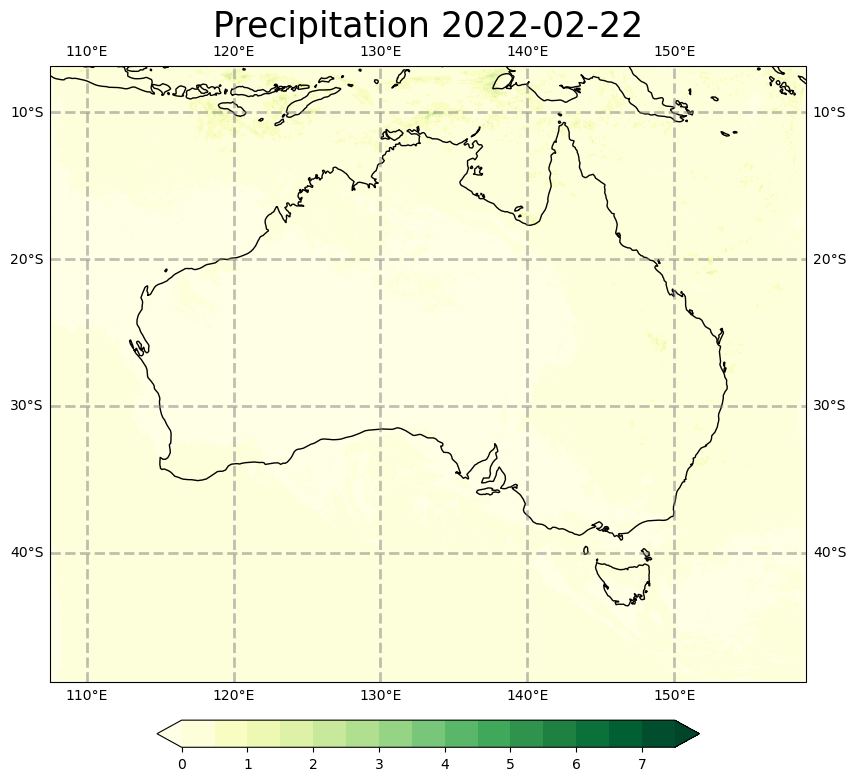

In [11]:
# Create an empty figure of a certain size
plt.figure(figsize=(10, 10))

# Set the projectioh map that we want to use and the colourmap
src = ccrs.PlateCarree()
ax = plt.axes(projection=src)
cmap=matplotlib.cm.get_cmap('YlGn')

# Create an array of values to change the colour by contour
levels = np.arange(0,8,0.5)

# Plot our data as a contour plot
ch = ax.contourf(pr_day.longitude, pr_day.latitude, pr_day[0,:,:], levels=levels, cmap=cmap, extend='both')

# Set the title
title = 'Precipitation 2022-02-22'
plt.title(title, size=25)

# Create gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=2, color='gray', alpha=0.5, linestyle='--')

# Change the resolution of the coastlines
ax.coastlines('50m', linewidth=1)

# Create the colourbar and place it below our plot
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
out=plt.colorbar(ch,cax=cax,extend='both',**kw)

So far we have only plotted the first timestep, in xarray is easy to select a specific time using `sel()`.<br>
Let's try to select the rainfall on the sixth day of the simulation the 27th of Feb.

In [19]:
pr_day6 = pr_day.sel(time="2022-02-27")

To create a plot without having to repeat the code above every time we change input data, we're going to create a function `rain_plot(pr_var, title)`. This will take two arguments: the variable and a title for the plot.

In [26]:
def rain_plot(var, plot_title):
    # Create an empty figure of a certain size
    plt.figure(figsize=(10, 10))

    # Set the projectioh map that we want to use and the colourmap
    src = ccrs.PlateCarree()
    ax = plt.axes(projection=src)
    cmap=matplotlib.cm.get_cmap('YlGn')

    # Create an array of values to change the colour by contour
    levels = np.arange(0,100,10)

    # Plot our data as a contour plot
    ch = ax.contourf(var.longitude, var.latitude, var, levels=levels, cmap=cmap, extend='both')

    # Set the title
    title = plot_title
    plt.title(title, size=25)

    # Create gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=2, color='gray', alpha=0.5, linestyle='--')

    # Change the resolution of the coastlines
    ax.coastlines('50m', linewidth=1)

    # Create the colourbar and place it below our plot
    cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
    out=plt.colorbar(ch,cax=cax,extend='both',**kw)

Now we can call the function to plot our selected data

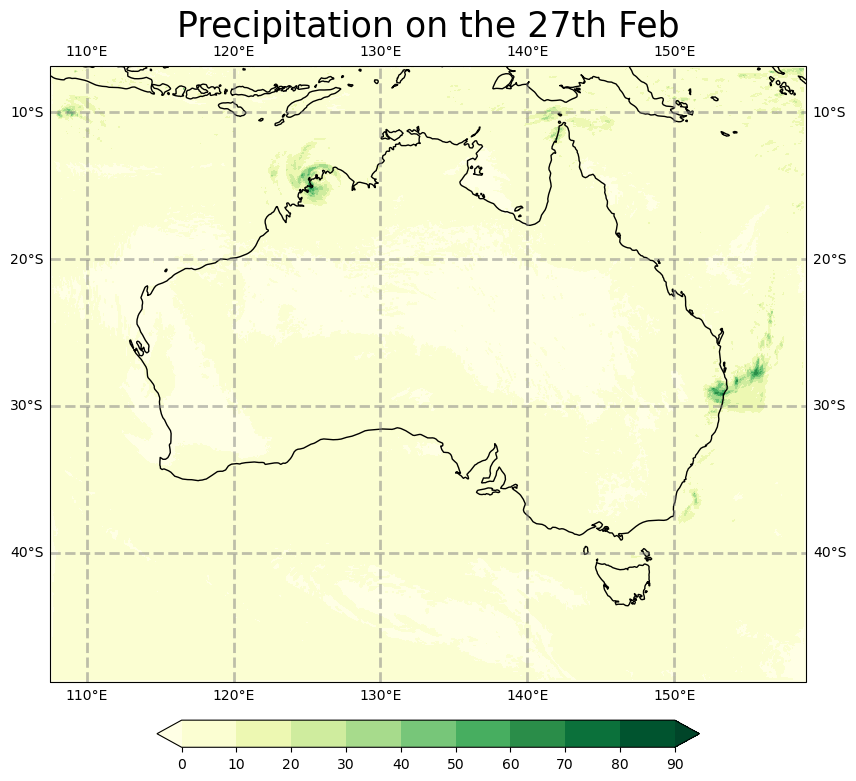

In [27]:
rain_plot(pr_day6, 'Precipitation on the 27th Feb')